In [1]:
%run ./ipy_setup.py
%matplotlib inline
#%run ../scripts/greedy_partitioner.py
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Graphics import GenomeDiagram
from reportlab.lib.units import cm

def translateContigName(cname):
    outstr = "%06dF" % (int(cname)-1)
    return outstr

In [540]:
xmap = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hmap_combine/alex_concat_hmaps_aligned.xmap', 
                   sep='\t', skiprows=8)
xmap = xmap.drop(xmap.index[0]) # first line after header is junk
mergemap = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hmap_combine/alex_merged_maps.txt', 
                   sep=' ')
hmap = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hmap_combine/alex_concat_hmaps.hmap', 
                   sep='\t', skiprows=9)
hmap = hmap.drop(hmap.index[0]) # first line after header is junk

cmap_q = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hmap_combine/alex_concat_hmaps_aligned_q.cmap', 
                   sep='\t', header=None, skiprows=10)
#cmap_q = cmap_q.drop(cmap_q.index[0]) # first line after header is junk
cmap_r = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hmap_combine/NIST_asm_2015-07-01_pa_ctg_BspQI_0Kb_0labels.cmap', 
                   sep='\t', header=None, skiprows=7)
#cmap_r = cmap_r.drop(cmap_r.index[0]) # first line after header is junk

xmap.RefContigID = xmap.RefContigID.astype(int)
xmap.RefStartPos = xmap.RefStartPos.astype(float)
xmap.RefEndPos = xmap.RefEndPos.astype(float)
xmap = xmap.sort(columns=['RefContigID','RefStartPos'])

block_reader = HapCutReader('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv13_mq10/hg002_hapcut_000000F.hapcut')

blockpos = []
for i in block_reader.blocks:
    block = block_reader.loc(i)
    blockpos.append([i, block.chrom, block.start, block.end])

opticalmap_all_a = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hmap_combine/alex_merged_maps.txt', sep=' ')
opticalmap_all_a = opticalmap_all_a[opticalmap_all_a['r_contig_id'] == 1]
#opticalmap_all.sort(columns='r_pos', inplace=True)
opticalmap_all = opticalmap_all_a[opticalmap_all_a['HapDelta'] != 0.0]
opticalmap_hapinform = opticalmap_all_a[opticalmap_all_a['HapSite'] != 3]

vcf_matches = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hg002_snps_opticalmap_matches_2_000000F.vcf', sep='\t', header=None)

In [561]:
sorted_keys = sorted([int(i) for i in block_ranges.keys()])
for key in sorted_keys:
    i = block_ranges[str(key)]
    print "block #:", key, "min:", i['min'], "max:", i['max'], "blocks:", i['ranges']

block #: 1 min: 33164599 max: 33280560 blocks: [[33164599, 33189034], [33218331, 33254375], [33263570, 33280560]]
block #: 2 min: 33004770 max: 33134061 blocks: [[33004770, 33067272], [33080573, 33091482], [33121509, 33134061]]
block #: 3 min: 32949083 max: 32970698 blocks: [[32949083, 32970698]]
block #: 4 min: 32868614 max: 32952641 blocks: [[32868614, 32910159], [32912300, 32925410], [32938884, 32952641]]
block #: 5 min: 32697542 max: 32843758 blocks: [[32697542, 32746303], [32748302, 32769461], [32780561, 32796421], [32799494, 32843758]]
block #: 6 min: 32603135 max: 32702483 blocks: [[32603135, 32619475], [32627703, 32702483]]
block #: 7 min: 32510036 max: 32582756 blocks: [[32510036, 32551988], [32553186, 32582756]]
block #: 8 min: 32422907 max: 32448696 blocks: [[32422907, 32448696]]
block #: 9 min: 32385919 max: 32415371 blocks: [[32385919, 32415371]]
block #: 10 min: 32060583 max: 32177698 blocks: [[32060583, 32091887], [32107692, 32139353], [32154849, 32177698]]
block #: 11 m

In [535]:
json_fp = open("/hpc/users/neffr01/jason_new/falcon_unzip_jason_071715/haplotypes_to_ranges_000000F.json", 'r')
block_ranges = json.load(json_fp)

In [547]:
gdd = GenomeDiagram.Diagram('XMap file')
gdt_features = gdd.new_track(1, greytrack=False, title="000000F")
gds_features = gdt_features.new_set()

#Add three features to show the strand options
state = 0
lastcontig = None
contigcount = 0
for a,i in xmap.iterrows():
    state += 1
    if i.RefContigID != 1:
        break
    #strand = +1 if i.Orientation == '+' else -1
    color = colors.lightgreen if state % 2 == 0 else colors.green
    feature = SeqFeature(FeatureLocation(int(i.RefStartPos), int(i.RefEndPos)), strand=+1)
    gds_features.add_feature(feature, name="q-" + i.QryContigID, label=True, color=color, 
                             label_position="middle", label_angle=0)#,
                         #sigil="ARROW", arrowhead_length=0.15)
for i in blockpos:
    state += 1
    color = colors.lightblue if state % 2 == 0 else colors.blue
    feature = SeqFeature(FeatureLocation(i[2], i[3], strand=-1))
    gds_features.add_feature(feature, name="b-" + str(i[0]), label=True, color=color, label_position="middle", 
                             label_angle=-180)
for a,i in opticalmap_all.iterrows():
    color = colors.yellow
    _,cmap_r_curr = cmap_r[(cmap_r[0] == 1) & (cmap_r[3] == i['r_site_id'])].iterrows().next()
    _,cmap_r_last = cmap_r[(cmap_r[0] == 1) & (cmap_r[3] == i['r_site_id']-1)].iterrows().next()
    #print cmap_r_curr, cmap_r_last
    feature = SeqFeature(FeatureLocation(int(cmap_r_last[5]), int(cmap_r_curr[5]), strand=1))
    gds_features.add_feature(feature, name="SV-" + str(int(i['r_site_id'])), label=True, color=color, label_position="middle", 
                             label_angle=0)

for a,i in opticalmap_hapinform.iterrows():
    color = colors.red
    feature = SeqFeature(FeatureLocation(int(i['r_pos']), int(i['r_pos'])+10, strand=0))
    gds_features.add_feature(feature, name="var-" + str(int(i[4])), label=True, color=color, label_position="middle", 
                             label_angle=0)

for key,val in block_ranges.iteritems():
    color = colors.purple
    minb = val['min']
    maxb = val['max']
    ranges = val['ranges']
    #print cmap_r_curr, cmap_r_last
    for minr, maxr in ranges:
        feature = SeqFeature(FeatureLocation(int(minr), int(maxr), strand=1))
        gds_features.add_feature(feature, name="JC-" + str(key), label=True, color=color, label_position="middle", 
                                 label_angle=0)

for a,i in vcf_matches.iterrows():
    color = colors.springgreen
    feature = SeqFeature(FeatureLocation(int(i[1]), int(i[1])+50, strand=-1))
    gds_features.add_feature(feature, name="VCF-" + str(a), label=True, color=color, label_position="bottom", 
                             label_angle=0, sigil="ARROW", arrowhead_length=0.5)
    
gdd.draw(format='linear', pagesize=(30*cm,30*cm), fragments=20,
       start=0, end=33000000)
gdd.write("/hpc/users/neffr01/2work/alex_na24385_phasing/contig000000F.jason.pdf", "pdf")

In [315]:
'''
manually interrogate:

block 3087 in hapcut blocks
optical variants 525 and 550
vcf variants line 2-4 from overlap file
optical contig q-20

'''

block = block_reader.loc(3087)
blockvars = [b for b in block.variants.values() if b.pos in (4207133, 4425224) ]
opticalvars = opticalmap_hapinform[[True if i in [525, 550] else False for i in opticalmap_hapinform[4]]]
vcfvars = vcf_matches[2:6:2]
print "optical variant line"
print opticalvars
print ""
print "vcf variant line"
print vcfvars
print ""
print "block variant line"
for v in blockvars:
    print v.chrom, v.pos, v.hap1, v.hap2


optical variant line
    0    1          2   3    4        5   6   7     8   9      10  11
13  20  111   858070.1   1  525  4207133   1   0  18.8  -1  35.68   0
14  20  133  1076495.5   1  550  4425218   2   0   4.7  -1  21.43   0

vcf variant line
         0        1  2  3  4       5  6                                                  7                        8                                                9
2  000000F  4207133  .  G  A  105.77  .  AC=1;AF=0.500;AN=2;BaseQRankSum=-0.165;DP=73;D...           GT:AD:DP:GQ:PL                        0/1:45,25:70:99:134,0,267
4  000000F  4425224  .  C  G  620.91  .  AB=0.52381;ABP=3.21711;AC=1;AF=0.5;AN=2;AO=22;...  GT:GQ:DP:RO:QR:AO:QA:GL  0/1:153.86:42:20:690:22:767:-68.4462,0,-61.5125

block variant line
000000F 4207133 1 0
000000F 4425224 0 1


In [419]:
import itertools
import math

In [491]:
opticalmap_hapinform['SitePhaseConf'] = opticalmap_hapinform['SitePhaseConf'].astype(float)
optmap_highsiteconf = opticalmap_hapinform[opticalmap_hapinform['SitePhaseConf'] >= 0]

/hpc/users/neffr01/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [494]:
sequences = dict( (s.name, s) for s in ht.FastaReader("/hpc/users/neffr01/jason_new/NIST_asm_2015-07-01_pa_ctg.fa") )

In [507]:
error_roc = []
opticalmap_hapinform['SitePhaseConf'] = opticalmap_hapinform['SitePhaseConf'].astype(float)
vcf_file = "/hpc/users/neffr01/jason_new/trio_analysis/aj_trio_phasebytrans.phased-trio.vcf.gz"
vcfr = pysam.TabixFile(vcf_file, 'r')
for conf in range(0,30):
    optmap_highsiteconf = opticalmap_hapinform[opticalmap_hapinform['SitePhaseConf'] >= conf]
    # write code to automate consistency checking
    het_vars = []
    #blockvariants = []
    #for k,block in block_reader.blocks.iteritems():
    #    blockvariants.extend(block.variants.values())
    for k,v in optmap_highsiteconf.iterrows():
        # for each opticalmap site, check to see if there is a corresponding line from the VCF
        #print sequences[translateContigName(v.r_contig_id)][int(v.r_pos-1):int(v.r_pos+6)]
        for i in vcfr.fetch(reference=translateContigName(v.r_contig_id), start=int(v.r_pos-1), end=int(v.r_pos+6)):
            varcall = ht.VariantCall.fromline(str(i))
            #blockvar = next((x for x in blockvariants if (x.pos in [varcall.pos.pos])), None)
            het_vars.append([v, varcall])
    # check if hap sites agree:
    het_vars = sorted(het_vars, key=lambda x: (x[0]['r_contig_id'], x[0]['r_pos']))
    cleaned_vars = []
    for opt,trio in het_vars:
        trio_gen = trio.get_original_line().split('\t')[9].split(':')[0]
        if trio_gen == "1|1": continue
        if "/" in trio_gen: continue
        if opt.HapSite == 0.0: continue
        #print opt['r_contig_id'], '\t ', int(opt.r_pos), '\t', int(opt['#q_contig_id']),'\t', int(opt.HapSite), trio_gen
        cleaned_vars.append([opt['r_contig_id'], int(opt.r_pos), int(opt['#q_contig_id']), int(opt.HapSite), trio_gen])

    total_errors = 0
    total_calls = 0
    otherhap = {1:2,2:1}
    for name, group in itertools.groupby(cleaned_vars, lambda x: x[2]):
        group = list(group)
        if len(group) < 2: continue
        #print name
        hap1 = []
        hap2 = []
        errors = 0
        total = 0
        for ref,pos,query,opthap,triohap in group:
            #print ref, pos, query, opthap, triohap
            if triohap == '1|0':
                hap1.append(opthap)
            elif triohap == '0|1':
                hap2.append(opthap)
        true_hap1 = round(np.mean(hap1),0)
        true_hap2 = int(round(np.mean(hap2),0)) if len(hap2) >= len(hap1) else otherhap[true_hap1]
        true_hap1 = int(true_hap1) if len(hap1) > len(hap2) else otherhap[true_hap2]
        #print name, hap1, hap2
        errors += sum([1 if i != true_hap1 else 0 for i in hap1])
        errors += sum([1 if i != true_hap2 else 0 for i in hap2])
        total = sum([1 for i in np.concatenate([hap1, hap2])])
        if errors*2 > total:
            true_hap1 = otherhap[true_hap1]
            true_hap2 = otherhap[true_hap2]
            errors = total-errors
        total -= 1
        total_errors += errors
        total_calls += total
        #print name, true_hap1, true_hap2, errors, total, round(float(errors)/total, 2)
    print conf, "switch error rate: ", round(float(total_errors)/total_calls, 4), total_errors, total_calls
    error_roc.append([conf,round(float(total_errors)/total_calls, 4), total_errors, total_calls])

0 switch error rate:  0.4186 18 43
1 switch error rate:  0.4286 15 35
2 switch error rate:  0.4286 15 35
3 switch error rate:  0.5172 15 29
4 switch error rate:  0.4615 12 26
5 switch error rate:  0.4762 10 21
6 switch error rate:  0.45 9 20
7 switch error rate:  0.4444 8 18
8 switch error rate:  0.4706 8 17
9 switch error rate:  0.4375 7 16
10 switch error rate:  0.4667 7 15
11 switch error rate:  0.5 7 14
12 switch error rate:  0.5385 7 13
13 switch error rate:  0.5385 7 13
14 switch error rate:  0.5 6 12
15 switch error rate:  0.5 6 12
16 switch error rate:  0.4545 5 11
17 switch error rate:  0.4545 5 11
18 switch error rate:  0.5 5 10
19 switch error rate:  0.5556 5 9
20 switch error rate:  0.5 4 8
21 switch error rate:  0.3333 2 6
22 switch error rate:  0.3333 2 6
23 switch error rate:  0.4 2 5
24 switch error rate:  0.3333 1 3
25 switch error rate:  0.3333 1 3
26 switch error rate:  0.3333 1 3
27 switch error rate:  0.3333 1 3
28 switch error rate:  0.3333 1 3
29 switch error rat

/hpc/users/neffr01/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [515]:
import matplotlib.gridspec as gridspec

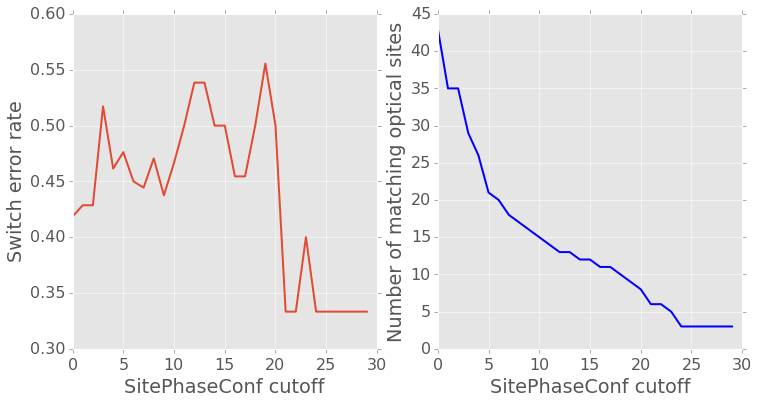

In [529]:
pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12,6)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax1.plot([i[0] for i in error_roc],
        [i[1] for i in error_roc])
ax2.plot([i[0] for i in error_roc],
          [i[3] for i in error_roc], color='b')
ax1.set_xlabel("SitePhaseConf cutoff")
ax1.set_ylabel("Switch error rate")
ax2.set_xlabel("SitePhaseConf cutoff")
ax2.set_ylabel("Number of matching optical sites")
plt.show()